## **Deep Unsupervised Learning course, HSE, fall-winter 2019**
## **HW 02**
#### **Student: Igor Tukh**

In [0]:
import os
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from torch.utils.data import DataLoader
from torch import nn

In [38]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
RESOURCES_PATH = 'gdrive/My Drive/Colab Notebooks/resources'
PKL_PATH = os.path.join(RESOURCES_PATH, 'hw2_q2.pkl')

In [0]:
def load_data():
  with open(PKL_PATH, 'rb') as pkl_file:
    return pickle.load(pkl_file)

In [0]:
data = load_data()

In [42]:
print('Train shape:', data['train'].shape)
print('Test shape:', data['test'].shape)

Train shape: (20000, 32, 32, 3)
Test shape: (6838, 32, 32, 3)


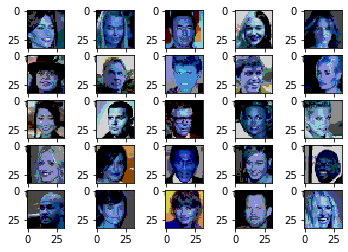

In [46]:
fig = plt.figure()
for ind, image in enumerate(data['train'][:25]):
  fig.add_subplot(5, 5, ind + 1)
  plt.imshow(image * 70)

In [0]:
train = torch.FloatTensor(data['train'].transpose(0, 3, 1, 2))
test = torch.FloatTensor(data['test'].transpose(0, 3, 1, 2))

In [48]:
print('Train shape:', train.shape)
print('Test shape:', test.shape)

Train shape: torch.Size([20000, 3, 32, 32])
Test shape: torch.Size([6838, 3, 32, 32])


In [0]:
batch_size = 16
num_epochs = 5
lr = 5e-4

In [0]:
train_batches = DataLoader(train, batch_size=batch_size, shuffle=True)
test_batches = DataLoader(test, batch_size=batch_size, shuffle=True)

In [0]:
class ResNetBlock(nn.Module):
  def __init__(self, n_filters):
    super(ResNetBlock, self).__init__()
    
    self._h = nn.Sequential(nn.Conv2d(n_filters, n_filters, kernel_size=(1, 1), stride=(1, 1)),
                            nn.ReLU(),
                            nn.Conv2d(n_filters, n_filters, kernel_size=(3, 3), stride=(1, 1), padding=1))
    
    self.h = nn.Sequential(nn.ReLU(),
                           nn.Conv2d(n_filters, n_filters, kernel_size=(1, 1), stride=(1, 1)))
    
  def forward(self, x):
    _h = self._h(x)
    h = self.h(_h)
    return h + _h

In [0]:
class AffineCoupling(nn.Module):
  def __init__(self, in_channels, n_filters=256, n_blocks=8):
    super(AffineCoupling, self).__init__()

    out_channels = 2 * in_channels
    self.layers = nn.Sequential(nn.Conv2d(in_channels, n_filters, kernel_size=(3, 3), stride=(1, 1), padding=1),
                                *[ResNetBlock(n_filters) for _ in range(n_blocks)],
                                nn.ReLU(),
                                nn.Conv2d(n_filters, out_channels, kernel_size=(3, 3), stride=(1, 1), padding=1))

  def forward(self, x):
    x1, x2 = x
    y1 = x1
    log_s, t = torch.chunk(self.simple_resnet(x1), 2, dim=1)
    # y2 = torch.exp(log_s) * (y1 + t)
    y2 = torch.exp(log_s) * (x2 + t)
    return (y1, y2), log_s.sum(dim=[1, 2, 3])

  def simple_resnet(self, x):
    # output = self.layers(x)
    # print(x.shape, output.shape)
    return self.layers(x)

In [0]:
def tuple_flip(x1, x2):
  return x2, x1

In [0]:
class Net(nn.Module):
  def __init__(self, in_channels):
    super(Net, self).__init__()

    affine_coupling_1 = nn.ModuleList([AffineCoupling(in_channels) for _ in range(4)])
    affine_coupling_2 = nn.ModuleList([AffineCoupling(2 * in_channels) for _ in range(3)])
    affine_coupling_3 = nn.ModuleList([AffineCoupling(4 * in_channels) for _ in range(3)])
    affine_coupling_4 = nn.ModuleList([AffineCoupling(8 * in_channels) for _ in range(3)])
    affine_coupling_5 = nn.ModuleList([AffineCoupling(16 * in_channels) for _ in range(3)])
  
    self.couplings = [(self.checkboard, affine_coupling_1), 
                      (self.channel, affine_coupling_2),
                      (self.checkboard, affine_coupling_3), 
                      (self.channel, affine_coupling_4),
                      (self.checkboard, affine_coupling_5)]

  def forward(self, x):
    total = 0
    for step, coupling in self.couplings:
      x, det = step(x, coupling)
      total += det
    return x, total

  def checkboard(self, x, couplings):
    x1, x2 = self.checkboard_split(x)    

    total = np.zeros(x1.shape)
    for layer in couplings:
      (x1, x2), det = layer((x1, x2))
      x1, x2 = tuple_flip(x1, x2)
      total += det
    
    x = self.inverse_checkboard_split(x1, x2)
    return x, total

  def channel(self, x, couplings):
    x = self.squeeze(x)
    x1, x2 = self.channel_split(x)    
    
    total = np.zeros(x1.shape)
    for layer in couplings:
      (x1, x2), det = layer((x1, x2))
      x1, x2 = tuple_flip(x1, x2)
      total += det
    
    x = self.inverse_channel_split(x1, x2)
    return x, total

  def checkboard_split(self, x):
    n, c, h, w = x.shape
    mask = np.array([[(i + j) % 2 == 0 for j in range(w)] for i in range(h)])
    mask = torch.from_numpy(mask).repeat(n, c, 1, 1)
    x1 = x[mask].reshape(n, c, h, w // 2)
    x2 = x[~mask].reshape(n, c, h, w // 2)
    return x1, x2

  def inverse_checkboard_split(self, x1, x2):
    n, c, h, w = x1.shape
    mask = np.array([[(i + j) % 2 == 0 for j in range(w * 2)] for i in range(h)])
    mask = torch.from_numpy(mask)
    x = torch.zeros(n, c, h, w * 2)
    x[:,:,mask] = x1.reshape(n, c, -1)
    x[:,:,~mask] = x2.reshape(n, c, -1)
    return x 

  def squeeze(self, x):
    n, c, h, w = x.shape
    return x.reshape(n, c * 4, h // 2, w // 2)

  def channel_split(self, x):
    return torch.chunk(x, 2, dim=1)

  def inverse_channel_split(self, x1, x2):
    return torch.cat((x1, x2), dim=1)